# 4c) Localization pipeline - Grenoble
The localization pipeline can be divided into two parts: building the dataset (which is offline) and localizing new images (which is online). We will cover both to allow you to experiment with the parameters. Thus, the first part will follow **build_map.ipynb**, and the second part will use **pipeline_small.ipynb**.

In [7]:
%load_ext autoreload
%autoreload 2
import tqdm, tqdm.notebook

tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path
import numpy as np
import random, time
import ipywidgets as widgets
from IPython.display import display
from collections import defaultdict
from pprint import pformat

from hloc import (
    extract_features,
    match_features,
    reconstruction,
    visualization,
    pairs_from_exhaustive,
    pairs_from_retrieval,
)
from hloc import colmap_from_nvm, triangulation, localize_sfm, visualization
from hloc.utils.downloader import *
from hloc.visualization import plot_images, read_image
from hloc.utils.parsers import group_and_sort_image_pairs_with_labels
from hloc.utils import viz_3d
from hloc.extract_features import ImageDataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Setup
Here we define some output paths and algorithms to use. 

In [2]:
db_images_dir = Path("/data/grenoble/images/db")
query_images_dir = Path('/data/grenoble/images/query')
outputs = Path("/data/outputs/grenoble_sfm/")

global_descriptor = "senet"           # dir, netvlad, openibl, eigenplaces, senet
keypoints_detector = "disk"           # sift, superpoint_aachen, superpoint_inloc, superpoint_max, r2d2, d2net-ss, sosnet, disk
keypoints_matcher = "disk+lightglue"  # NN-mutual, NN-ratio, adalam, NN-superpoint, superglue-fast, superglue, superpoint+lightglue 

In [3]:
sfm_pairs = outputs / (f"pairs-{global_descriptor}.txt")
loc_pairs = outputs / (f"pairs-{keypoints_detector}.txt")
sfm_dir = outputs / (f"sfm_{keypoints_matcher}")
features = outputs / (f"features_{keypoints_detector}.h5")
matches = outputs / (f"matches_{keypoints_detector}.h5")

retrieval_conf = extract_features.confs[global_descriptor]
feature_conf = extract_features.confs[keypoints_detector]
matcher_conf = match_features.confs[keypoints_matcher]

## Visualise the database images

[2024/02/09 08:33:28 hloc INFO] Found 24 images in root /data/grenoble/images/db.


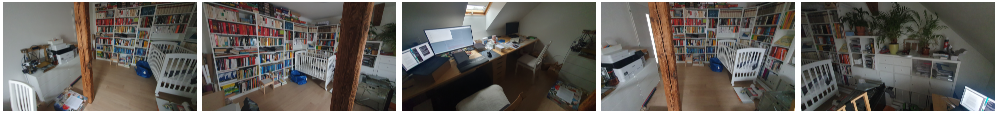

In [4]:
db_images = ImageDataset(db_images_dir, {"resize_max": 1024}, None)
plot_images([read_image(db_images_dir / r) for r in random.sample(db_images.names, 5)], dpi=25)

## [OFFLINE] Find image pairs via image retrieval

In [8]:
retrieval_path = extract_features.main(retrieval_conf, db_images_dir, outputs)
pairs = pairs_from_retrieval.main(retrieval_path, sfm_pairs, num_matched=10)

[2024/02/09 08:34:59 hloc INFO] Extracting local features with configuration:
{'model': {'model_name': 'SENet_R50_con',
           'name': 'senet',
           'resnet_size': 50,
           'scale_list': [0.7071, 1.0, 1.4142]},
 'output': 'global-feats-senet',
 'preprocessing': {'resize_max': 1024}}
[2024/02/09 08:34:59 hloc INFO] Found 24 images in root /data/grenoble/images/db.
[2024/02/09 08:34:59 hloc INFO] Skipping the extraction.
[2024/02/09 08:34:59 hloc INFO] Extracting image pairs from a retrieval database.
[2024/02/09 08:34:59 hloc INFO] Found 240 pairs.


## [OFFLINE] Extract and match local features (keypoints)

In [10]:
feature_path = extract_features.main(feature_conf, db_images_dir, outputs)
match_path = match_features.main(matcher_conf, sfm_pairs, feature_conf["output"], outputs)

[2024/02/09 08:35:15 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
[2024/02/09 08:35:15 hloc INFO] Found 24 images in root /data/grenoble/images/db.
[2024/02/09 08:35:15 hloc INFO] Skipping the extraction.
[2024/02/09 08:35:15 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}


  0%|          | 0/71 [00:00<?, ?it/s]

KeyboardInterrupt: 

## [OFFLINE] Incremental SfM
Run incremental Structure-From-Motion and display the reconstructed 3D model.

In [21]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)

[2024/02/08 12:33:01 hloc INFO] Creating an empty database...
[2024/02/08 12:33:01 hloc INFO] Importing images into the database...
[2024/02/08 12:33:01 hloc INFO] Importing features into the database...


  0%|          | 0/10 [00:00<?, ?it/s]

[2024/02/08 12:33:01 hloc INFO] Importing matches into the database...


  0%|          | 0/45 [00:00<?, ?it/s]

[2024/02/08 12:33:02 hloc INFO] Performing geometric verification of the matches...
I20240208 12:33:02.060886 436183 misc.cc:198] 
Custom feature matching
I20240208 12:33:02.064383 436183 feature_matching.cc:1021] Matching block [1/1]
I20240208 12:33:02.501943 436183 feature_matching.cc:46]  in 0.438s
I20240208 12:33:02.505909 436183 timer.cc:91] Elapsed time: 0.007 [minutes]
[2024/02/08 12:33:02 hloc INFO] Running 3D reconstruction...
I20240208 12:33:02.516544 436255 misc.cc:198] 
Loading database
I20240208 12:33:02.517218 436255 database_cache.cc:54] Loading cameras...
I20240208 12:33:02.517246 436255 database_cache.cc:64]  10 in 0.000s
I20240208 12:33:02.517258 436255 database_cache.cc:72] Loading matches...
I20240208 12:33:02.517691 436255 database_cache.cc:78]  45 in 0.000s
I20240208 12:33:02.517704 436255 database_cache.cc:94] Loading images...
I20240208 12:33:02.519138 436255 database_cache.cc:143]  10 in 0.001s (connected 10)
I20240208 12:33:02.519150 436255 database_cache.cc:1

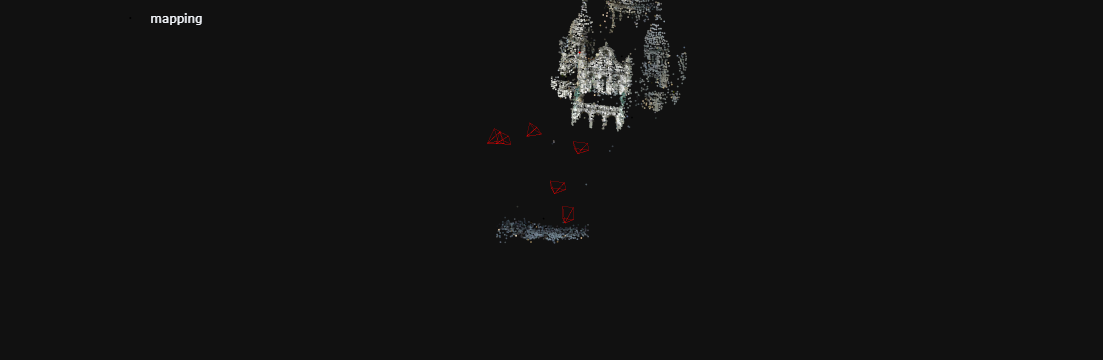

In [22]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(
    fig, model, color="rgba(255,0,0,0.5)", name="mapping", points_rgb=True
)
fig.show()

We also visualize which keypoints were triangulated into the 3D model.

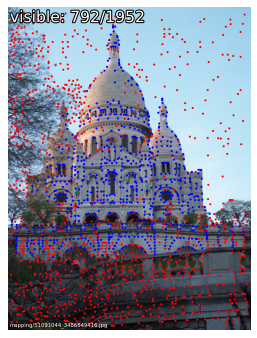

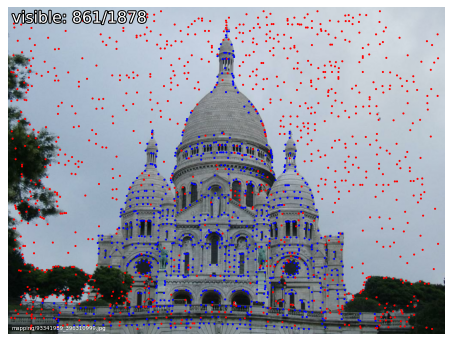

In [9]:
visualization.visualize_sfm_2d(model, images, color_by="track_length", n=3)

# Localization
Now that we have a 3D map of the scene, we can localize any image.

## Visualise the query images 
Upload the images using the "Upload" button and store it by "Save Image(s)".

In [ ]:
query_images_dir = Path('/data/grenoble/images/query')
query_images_dir.mkdir(exist_ok=True, parents=True)

uploader = widgets.FileUpload(
    accept='image/*',  # Accept only images
    multiple=True  # Allow single file upload
)
save_button = widgets.Button(description="Save Image(s)")
save_button.on_click(lambda change: save_uploaded_file(uploader.value, query_images_dir))
display(uploader, save_button)

In [ ]:
query_images = ImageDataset(query_images_dir, {"resize_max": 1024}, None)
plot_images([read_image(query_images_dir / r) for r in random.sample(query_images.names, min([len(query_images.names), 10]))], dpi=25)

## [ONLINE] Find image pairs via image retrieval
We extract global and local features for the query image.

In [16]:
query_feature_path = extract_features.main(feature_conf, query_images_dir, output_path)
query_descriptors_path = extract_features.main(retrieval_conf, query_images_dir, output_path)

[2024/02/08 12:32:06 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 4096, 'name': 'superpoint', 'nms_radius': 3},
 'output': 'feats-superpoint-n4096-r1024',
 'preprocessing': {'grayscale': True, 'resize_max': 1024}}


Loaded SuperPoint model


  0%|          | 0/1 [00:00<?, ?it/s]

[2024/02/08 12:32:07 hloc INFO] Finished exporting features.
[2024/02/08 12:32:07 hloc INFO] Found 10 pairs.
[2024/02/08 12:32:07 hloc INFO] Matching local features with configuration:
{'model': {'features': 'superpoint', 'name': 'lightglue'},
 'output': 'matches-superpoint-lightglue'}


  0%|          | 0/10 [00:00<?, ?it/s]

[2024/02/08 12:32:07 hloc INFO] Finished exporting matches.


Match the global descriptor to find similar images in the map.

In [ ]:
pairs_from_retrieval.main(query_descriptors_path, query_pairs_path, 50, query_prefix='query', \
    db_model=reference_sfm, db_descriptors = db_descriptors_path)

Match the local feature points (keypoints) between query image and the images from the image retrieval. 

In [ ]:
loc_match_path = match_features.main(matcher_conf, query_pairs_path, feature_conf['output'],\
    output_path, None, db_feature_path)

We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length.

In [ ]:
localize_sfm.main(
    reference_sfm,
    Path(query_file),
    query_pairs_path,
    query_feature_path,
    loc_match_path,
    results_path,
    covisibility_clustering=False)  # not required with SuperPoint+SuperGlue

We read the EXIF data of the query to infer a rough initial estimate of camera parameters like the focal length. Then we estimate the absolute camera pose using PnP+RANSAC and refine the camera parameters.

found 514/1097 inlier correspondences.


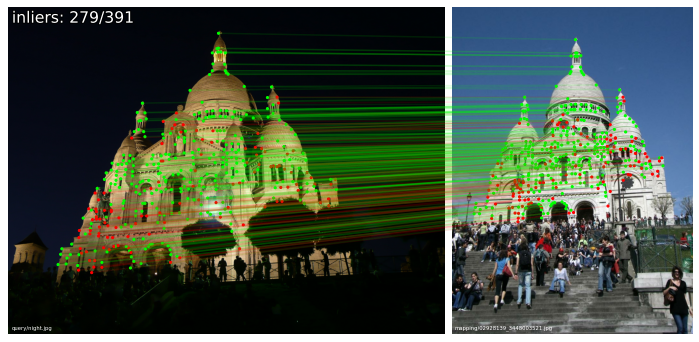

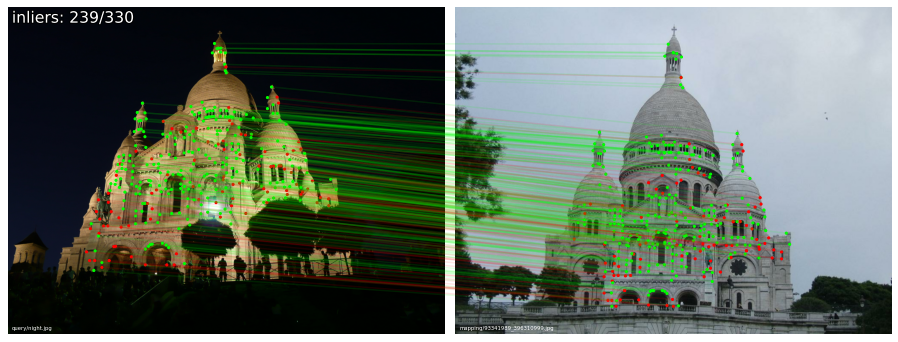

In [17]:
import pycolmap
from hloc.localize_sfm import QueryLocalizer, pose_from_cluster

camera = pycolmap.infer_camera_from_image(images / query)
ref_ids = [model.find_image_with_name(r).image_id for r in references]
conf = {
    "estimation": {"ransac": {"max_error": 12}},
    "refinement": {"refine_focal_length": True, "refine_extra_params": True},
}
localizer = QueryLocalizer(model, conf)
ret, log = pose_from_cluster(localizer, query, camera, ref_ids, features, matches)

print(f'found {ret["num_inliers"]}/{len(ret["inliers"])} inlier correspondences.')
visualization.visualize_loc_from_log(images, query, log, model)

We visualize the correspondences between the query images a few mapping images. We can also visualize the estimated camera pose in the 3D map.

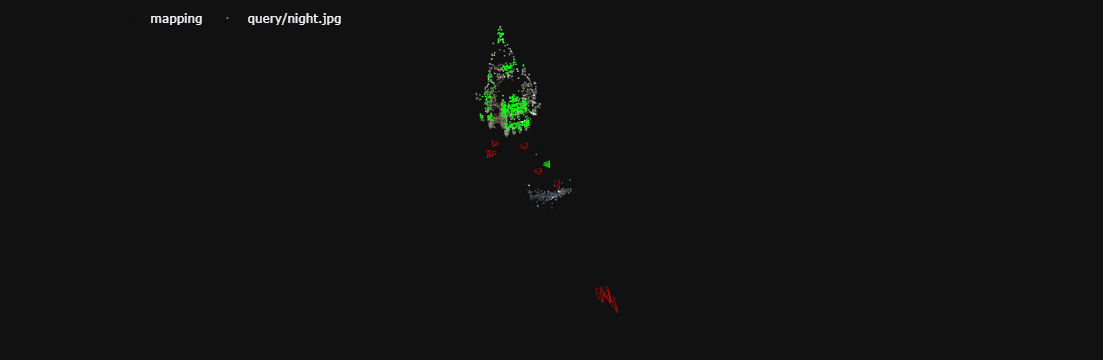

In [14]:
pose = pycolmap.Image(cam_from_world=ret["cam_from_world"])
viz_3d.plot_camera_colmap(
    fig, pose, camera, color="rgba(0,255,0,0.5)", name=query, fill=True
)
# visualize 2D-3D correspodences
inl_3d = np.array(
    [model.points3D[pid].xyz for pid in np.array(log["points3D_ids"])[ret["inliers"]]]
)
viz_3d.plot_points(fig, inl_3d, color="lime", ps=1, name=query)
fig.show()